In [58]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [59]:
import os  
import json

In [60]:
df = pd.read_csv('btc.csv')
df.head(5) 

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
1,2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2,2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
3,2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
4,2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0


In [61]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits'],
      dtype='object')

In [62]:
df.drop([ 'Open', 'High', 'Low',  'Dividends', 'Stock Splits', 'Volume'], inplace = True, axis = 1)

In [63]:
df['time'] = pd.to_datetime(df['Date'])
df['formatted_time'] = df['time'].dt.strftime('%d-%m-%Y')
df['formatted_time']

0       17-09-2014
1       18-09-2014
2       19-09-2014
3       20-09-2014
4       21-09-2014
           ...    
3543    30-05-2024
3544    31-05-2024
3545    01-06-2024
3546    02-06-2024
3547    03-06-2024
Name: formatted_time, Length: 3548, dtype: object

In [64]:
df.drop([ 'Date', 'time'], inplace = True, axis = 1)

In [65]:
df

,Close,formatted_time
0,457.334015,17-09-2014
1,424.440002,18-09-2014
2,394.795990,19-09-2014
3,408.903992,20-09-2014
4,398.821014,21-09-2014
...,...,...
3543,68364.992188,30-05-2024
3544,67491.414062,31-05-2024
3545,67706.937500,01-06-2024
3546,67751.601562,02-06-2024


In [66]:
import pandas_ta as ta
 
df['SMA'] = ta.sma(df['Close'], length=5) 
df['EMA'] = ta.ema(df['Close'], length=5) 
df['RSI'] = ta.rsi(df['Close'], length=14) 

In [67]:
df.fillna(0, inplace = True)

In [68]:
new_df = df.copy()

In [69]:
X = new_df.drop(['Close', 'formatted_time'], axis = 1).values
Y = new_df['Close'].values

In [70]:
X

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [6.78875312e+04, 6.79410445e+04, 5.29987433e+01],
       [6.77786078e+04, 6.78778969e+04, 5.31387865e+01],
       [6.80777047e+04, 6.82764573e+04, 5.72033397e+01]])

In [71]:
Y

array([  457.33401489,   424.44000244,   394.79598999, ...,
       67706.9375    , 67751.6015625 , 69073.578125  ])

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [73]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 


In [74]:
rf = RandomForestRegressor()
 
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300]
}
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3)
grid_search_rf.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [50, 100, 150, 200, 250, 300]})

In [75]:
best_rf = grid_search_rf.best_estimator_
best_rf

RandomForestRegressor(n_estimators=300)

In [76]:
y_pred_rf = best_rf.predict(X_test) 

In [77]:
rf_metrics = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    'MSE': mean_squared_error(y_test, y_pred_rf),
    'MAE': mean_absolute_error(y_test, y_pred_rf),
    'R2': r2_score(y_test, y_pred_rf)
}
print(rf_metrics)


{'RMSE': 552.913497663636, 'MSE': 305713.3358986356, 'MAE': 265.75625760888227, 'R2': 0.9990771483383322}


In [78]:
data = df[len(df) - 15:]

In [81]:
import pickle 
with open('btc.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

In [82]:
import pickle

In [83]:
for i in range(2):
    sma = ta.sma(data['Close'], length=5).iloc[-1]
    ema = ta.ema(data['Close'], length=5).iloc[-1]
    rsi = ta.rsi(data['Close'], length=14).iloc[-1]
    # sma_5, ema_5, rsi_14 = scaler.fit_transform(np.array([sma, ema, rsi]).reshape(-1, 1))
    # new_close = best_rf.predict([[0.163528, 0.0, 0.0, 0.0, 1.0, 0.0, sma_5[0], ema_5[0], rsi_14[0]]])
    new_close = best_rf.predict([[sma, ema, rsi]])
    print(new_close)
    new_row = pd.DataFrame({"Close": new_close, "formatted_time" : "0", "SMA" : sma, "EMA" : ema, "RSI" : rsi})
    data = pd.concat([data, new_row], ignore_index= True)
    

[66213.21785156]
[64920.6802474]


In [ ]:
import pickle 
with open('btc.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

In [101]:
import pandas as pd
import pickle
import pandas_ta as ta
from datetime import timedelta
import matplotlib.pyplot as plt
def file(Type):
    if Type == 'btc':
        df = pd.read_csv('btc.csv', usecols=['Date', 'Close'])
        with open('btc.pkl', 'rb') as f:
            model = pickle.load(f)
        df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
        for i in range(2):
            sma = ta.sma(df['Close'], length=5).iloc[-1]
            ema = ta.ema(df['Close'], length=5).iloc[-1]
            rsi = ta.rsi(df['Close'], length=14).iloc[-1] 
            new_close = model.predict([[sma, ema, rsi]])
            new_date = df['Date'].iloc[-1] + timedelta(days=1)
            new_row = {
                "Date": new_date,
                "Close": new_close,
                "SMA": sma,
                "EMA": ema,
                "RSI": rsi
            }
            df = pd.concat([df, pd.DataFrame(new_row)], ignore_index=True)
        last_10_days = df.tail(10)
        print(last_10_days) 
        plt.style.use('dark_background')
        plt.figure(figsize=(12, 6))
        plt.plot(last_10_days['Date'], last_10_days['Close'], linestyle='-', color='b', )
        plt.title('BTC Close Prices Over Time')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.grid(True)
        plt.savefig('btc_last_10_days.png')
        plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_2824\3056444743.py:11: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)


                          Date         Close           SMA           EMA  \
3540 2024-05-27 00:00:00+00:00  69394.554688           NaN           NaN   
3541 2024-05-28 00:00:00+00:00  68296.218750           NaN           NaN   
3542 2024-05-29 00:00:00+00:00  67578.093750           NaN           NaN   
3543 2024-05-30 00:00:00+00:00  68364.992188           NaN           NaN   
3544 2024-05-31 00:00:00+00:00  67491.414062           NaN           NaN   
3545 2024-06-01 00:00:00+00:00  67706.937500           NaN           NaN   
3546 2024-06-02 00:00:00+00:00  67751.601562           NaN           NaN   
3547 2024-06-03 00:00:00+00:00  69073.578125           NaN           NaN   
3548 2024-06-04 00:00:00+00:00  68961.387396  68077.704687  68276.457296   
3549 2024-06-05 00:00:00+00:00  68927.909349  68196.983729  68504.767329   

            RSI  
3540        NaN  
3541        NaN  
3542        NaN  
3543        NaN  
3544        NaN  
3545        NaN  
3546        NaN  
3547        NaN  
3

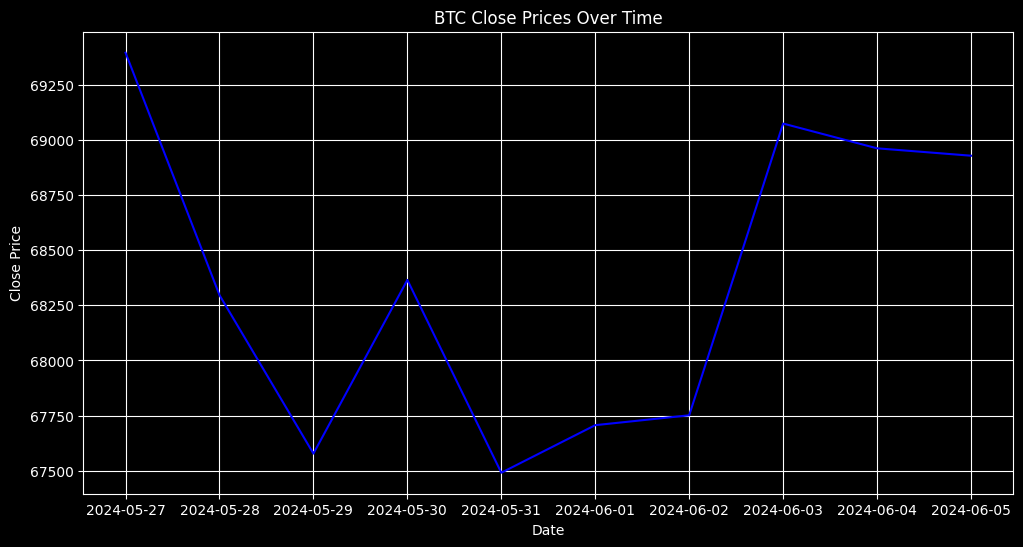

In [102]:
file("btc")
